In [13]:
import numpy as np
import pandas as pd
import os
import time
import pydicom as dicom
import pydicom
import matplotlib.pyplot as plt
import json
import glob
import collections
#from pydicom.pixel_data_handlers.util import apply_voi_lut
#import cv2
#from skimage import measure
#from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import random
from glob import glob
import warnings
warnings.filterwarnings('ignore')

### Load Data

In [3]:
label_coordinates_df = pd.read_csv('data/train_label_coordinates.csv')
train_series = pd.read_csv('data/train_series_descriptions.csv')
df_train = pd.read_csv('data/train.csv')
df_sub = pd.read_csv('data/sample_submission.csv')
test_series = pd.read_csv('data/test_series_descriptions.csv')

In [4]:
label_coordinates_df.head()

,study_id,series_id,instance_number,condition,level,x,y
0,4003253,702807833,8,Spinal Canal Stenosis,L1/L2,322.831858,227.964602
1,4003253,702807833,8,Spinal Canal Stenosis,L2/L3,320.571429,295.714286
2,4003253,702807833,8,Spinal Canal Stenosis,L3/L4,323.030303,371.818182
3,4003253,702807833,8,Spinal Canal Stenosis,L4/L5,335.292035,427.327434
4,4003253,702807833,8,Spinal Canal Stenosis,L5/S1,353.415929,483.964602


### Load Images

In [5]:
folder_path = 'images/train_images/100206310/1012284084'
dicom_files = [f for f in os.listdir(folder_path) if f.endswith('.dcm')]

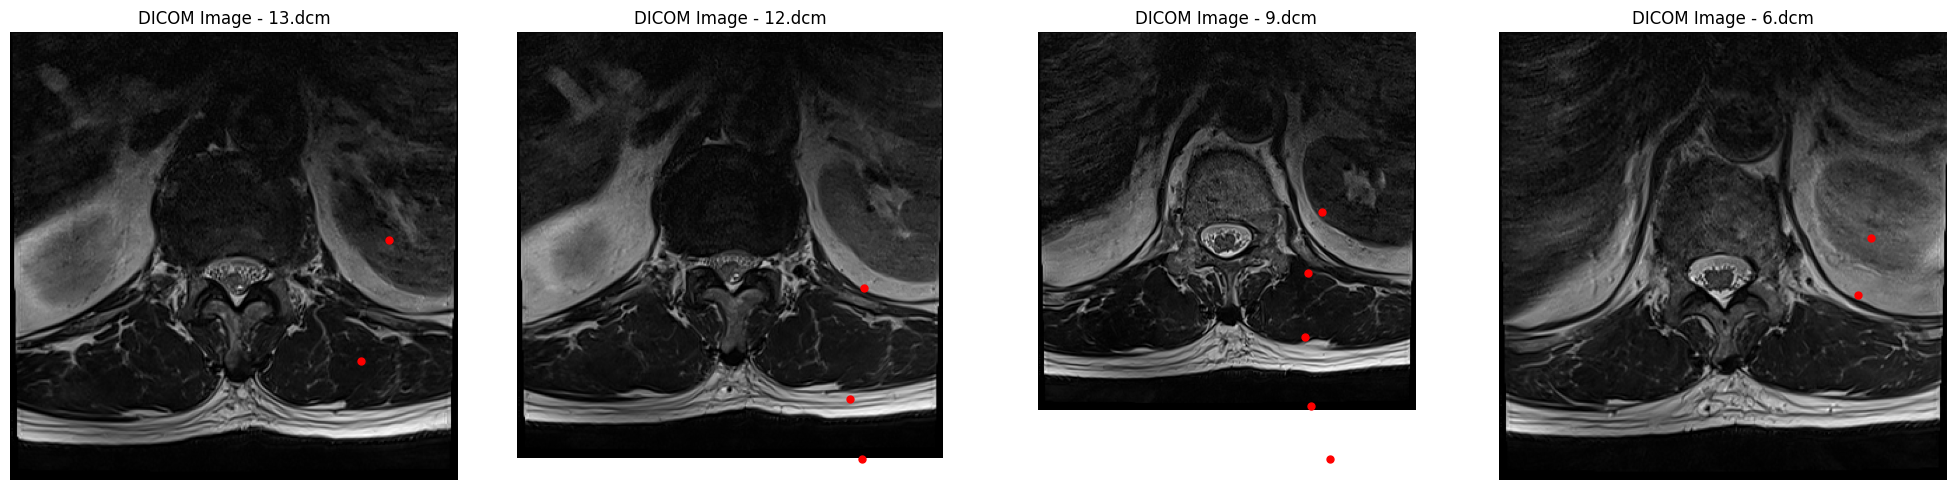

In [ ]:
folder_path = 'images/train_images/4003253/702807833'
dicom_files = [f for f in os.listdir(folder_path) if f.endswith('.dcm')]
label_coordinates_df = pd.read_csv('data/train_label_coordinates.csv')

study_id = folder_path.split('/')[-2]
study_label_coordinates = label_coordinates_df[label_coordinates_df['study_id'] == int(study_id)]
filtered_dicom_files = []
filtered_label_coordinates = []

for dicom_file in dicom_files:
    instance_number = int(dicom_file.split('.')[0])
    corresponding_coordinates = study_label_coordinates[study_label_coordinates['instance_number'] == instance_number]
    if not corresponding_coordinates.empty:
        filtered_dicom_files.append(dicom_file)
        filtered_label_coordinates.append(corresponding_coordinates)
fig, axs = plt.subplots(1, 4, figsize=(20, 5))
second_row_index = 1
second_row_images = filtered_dicom_files[second_row_index : second_row_index + 4]
second_row_coordinates = filtered_label_coordinates[second_row_index : second_row_index + 4]

for i, (dicom_file, label_coordinates) in enumerate(zip(second_row_images, second_row_coordinates)):
    dicom_file_path = os.path.join(folder_path, dicom_file)
    dicom_data = pydicom.dcmread(dicom_file_path)
    image = dicom_data.pixel_array   
    axs[i].imshow(image, cmap='gray')
    axs[i].set_title(f'DICOM Image - {dicom_file}')
    axs[i].axis('off')   
    for _, row in label_coordinates.iterrows():
        axs[i].plot(row['x'], row['y'], 'ro', markersize=5) 
        
plt.tight_layout()
plt.show()

In [ ]:
df_train.head()

In [ ]:
def load_dicom(path):
    dicom = pydicom.read_file(path)
    data = dicom.pixel_array
    data = data - np.min(data)
    if np.max(data) != 0:
        data = data / np.max(data)
    data = (data * 255).astype(np.uint8)
    return data

In [ ]:
df_sub.shape,test_series.shape,train_series.shape,label_coordinates_df.shape,df_train.shape